In [2]:
import numpy as np
import math
import random
import time
from gurobipy import*
from gurobipy import GRB
import matplotlib.pyplot as plt
import pandas as pd

## Función para generación aleatoria de hipergrafos

In [3]:
def rand_hgraf(n,m,d):
    E = np.random.randint(2,d+1,size=(m))
    M = np.arange(m)
    N = np.arange(n)
    A = np.zeros((n,m))
    
    for j in M:
        t = 0
        while t < E[j]:
            s = int(np.random.choice(N,size=1))
            A[s,j] = 1
            t = np.sum(A[:,j])
    return A

In [3]:
#Tamaño promedio de las hiperaristas
def prom(A):
    m = A.shape[1]
    P = []
    for y in range(m):
        P.append(sum(A[:,y]))
    p = np.average(P)
    return p

#Tamaño máximo de las hiperaristas
def tamax(A):
    S = np.sum(A,axis=0)
    m = int(np.max(S))
    return m

#Vértices cubiertos por hiperaristas
def vert_cover(A,h):
    n = A.shape[0]
    S= np.zeros(n)
    for j in h:
        S += A[:,j]
    vc = np.where(S!=0)[0]
    return len(vc)

def union(A,s):
    U = np.sum(A[:,s],axis=1)
    u = np.where(U!=0)[0]
    return u

#Vértices en la interesección de las hiperaristas
def inter(A,e1,e2):
    I = A[:,e1]+A[:,e2]
    i = np.where(I>1)[0]
    return i

## Funciones para desigualdades válidas

In [4]:
#Hiperaristas tipo hoja
def hoja(A):
    n = A.shape[0]
    S = np.sum(A,axis=1)
    h = []
    for i in range(n):
        if S[i]==1:
            j = np.where(A[i,:]==1)[0][0]
            h.append(j)
    return h

#Hiperaristas contenidas
def cont(A):
    m = A.shape[1]   #número de hiperaristas
    tmax = tamax(A)
    h = {}
    for t in range(2,tmax+1):
        E = []
        for j in range(m):
            if sum(A[:,j])==t:
                E.append(j)
        h.update({t: E})
    C = {}
    for c_out in range(tmax,2,-1):
        for eo in h[c_out]:
            L = []
            for c_in in range(c_out-1,1,-1):
                for ei in h[c_in]:
                    d = A[:,ei]+A[:,eo]
                    s = len(np.where(d==2)[0])
                    if s == c_in:
                        L.append(ei)
            if len(L)>0:
                C.update({eo:L})
    return C

## Formulación $\mathcal{F}3$

In [5]:
def F3(A,W,R,K,Lc,Uc):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.10a)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) >= Lc for k in C)
    #(3.10b)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) <= Uc for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,nods,g

## Formulación $\mathcal{F}3$ con planos cortantes

In [6]:
#Tipo hoja
def F3_pc1(A,W,R,K,Lc,Uc):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.10a)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) >= Lc for k in C)
    #(3.10b)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) <= Uc for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Hiperaristas tipo hoja
    for h in hoja(A):
        modelo.addConstr(quicksum(y[h,k] for k in C) == 1)
        modelo._cbCuts+=1
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [7]:
#Eliminacion de simetrias
def F3_pc2(A,W,R,K,Lc,Uc):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.10a)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) >= Lc for k in C)
    #(3.10b)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) <= Uc for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [8]:
#Hiperaristas contenidas
def F3_pc3(A,W,R,K,Lc,Uc):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.10a)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) >= Lc for k in C)
    #(3.10b)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) <= Uc for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        count=0
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [9]:
def F3_pc23(A,W,R,K,Lc,Uc):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.10a)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) >= Lc for k in C)
    #(3.10b)
    modelo.addConstrs(quicksum(R[i]*x[i,k] for i in N) <= Uc for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        count=0
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [10]:
n = 45
m = 300
k = 3
tam = 5
r = int(n/k)
A = rand_hgraf(n,m,tam)
W = np.random.randint(1,21,size=m)
R = np.random.randint(1,10,size=m)
X,E,tr,val,nods,gap = F3(A,W,R,k,5*r,10*r)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-08-03


In [11]:
X

[[0, 2, 3, 4, 6, 9, 10, 12, 16, 17, 18, 22, 23, 26, 27, 31, 37, 41],
 [1, 7, 8, 11, 13, 14, 15, 20, 25, 29, 32, 38, 42, 44],
 [5, 19, 21, 24, 28, 30, 33, 34, 35, 36, 39, 40, 43]]

In [12]:
E

[[28, 46, 48, 75, 126, 145, 212, 259],
 [17, 154, 166, 168, 179],
 [10, 112, 119, 178]]

In [13]:
for x in E[1]:
    for y in E[2]:
        print(inter(A,x,y))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [14]:
vert_cover(A,E[0]),len(X[0])

(18, 18)

In [15]:
val

40.0

In [16]:
tr

1.787750244140625

In [17]:
nods

2408.0

In [18]:
X1,E1,tr1,val1,nods1,gap1 = F3_pc2(A,W,R,k,5*r,10*r)

In [19]:
X1

[[0, 2, 3, 4, 6, 9, 10, 12, 16, 17, 18, 22, 23, 26, 27, 31, 37, 41],
 [1, 7, 8, 11, 13, 14, 15, 20, 25, 29, 32, 38, 42, 44],
 [5, 19, 21, 24, 28, 30, 33, 34, 35, 36, 39, 40, 43]]

In [20]:
E1

[[28, 46, 48, 75, 126, 145, 212, 259],
 [17, 154, 166, 168, 179],
 [10, 112, 119, 178]]

In [21]:
val1

40.0

In [22]:
nods1

[2188.0, 3]

In [23]:
tr1

1.5972728729248047

In [24]:
P = np.array([[45,100],
              [45,200],
              [45,500],
              [90,150],
              [90,500],
              [90,1000],
              [150,300],
              [150,800],
              [150,1500],
              [180,400],
              [180,1000],
              [180,2000]])

tam = {45:[2,5,10],
       90:[2,5,10,20],
       150:[2,5,10,20],
       180:[2,5,10,20]}
R = []

for p in P:
    for t in tam[p[0]]:
        n = p[0]
        m = p[1]
        K = 3
        r = int(n/k)
        sol =None
        tr=0
        i=0
        while sol==None and tr<1000:
            A = rand_hgraf(n,m,t)
            pr = prom(A)
            W = np.random.randint(1,21,size=m)
            Re = np.random.randint(1,11,size=m)
            print(p,t)
            if t==2 and m/n <3:
                V,E,tr,sol,nod,g = F3(A,W,Re,k,5*r,10*r)
                V1,E1,tr1,sol1,nod1,g1 = F3_pc1(A,W,Re,k,5*r,10*r)
                V2,E2,tr2,sol2,nod2,g2 = F3_pc2(A,W,Re,k,5*r,10*r)
                V3,E3,tr3,sol3,nod3,g3 = None,None,None,None,None,None
                V23,E23,tr23,sol23,nod23,g23 = F3_pc23(A,W,Re,k,5*r,10*r)
            else:
                V,E,tr,sol,nod,g = F3(A,W,Re,k,5*r,10*r)
                V1,E1,tr1,sol1,nod1,g1 = None,None,None,None,None,None
                V2,E2,tr2,sol2,nod2,g2 = F3_pc2(A,W,Re,k,5*r,10*r)
                V3,E3,tr3,sol3,nod3,g3 = F3_pc3(A,W,Re,k,5*r,10*r)
                V23,E23,tr23,sol23,nod23,g23 = F3_pc23(A,W,Re,k,5*r,10*r)
            i += 1
            if i >=10:
                break        
        Tr=[tr,tr1,tr2,tr3,tr23]
        S=[sol,sol1,sol2,sol3,sol23]
        Nd=[nod,nod1,nod2,nod3,nod23]
        G=[g,g1,g2,g3,g23]
        print(Tr,S)
        print(Nd)
        R.append([p,pr,t,[5*r,10*r],Tr,S,Nd,G])

[ 45 100] 2
[0.01197052001953125, 0.01194000244140625, 0.013952255249023438, None, 0.015472412109375] [140.0, 140.0, 140.0, None, 140.0]
[1.0, [1.0, 1], [1.0, 3], None, [1.0, 3]]
[ 45 100] 5
[0.3227558135986328, None, 0.5703487396240234, 0.40905189514160156, 1.1736030578613281] [110.0, None, 110.0, 110.0, 110.0]
[288.0, None, [2633.0, 3], [288.0, 7], [2241.0, 46]]
[ 45 100] 10
[ 45 100] 10
[3.239957809448242, None, 2.6065940856933594, 5.907161712646484, 5.95976448059082] [88.0, None, 88.0, 88.0, 88.0]
[4423.0, None, [3269.0, 3], [5644.0, 203], [5894.0, 208]]
[ 45 200] 2
[0.011966705322265625, None, 0.011980056762695312, 0.012968063354492188, 0.011997222900390625] [96.0, None, 96.0, 96.0, 96.0]
[1.0, None, [1.0, 3], [1.0, 0], [1.0, 3]]
[ 45 200] 5
[2.539274215698242, None, 2.5975875854492188, 6.736644744873047, 3.6318302154541016] [50.0, None, 50.0, 50.0, 50.0]
[7317.0, None, [2803.0, 3], [7698.0, 130], [2177.0, 21]]
[ 45 200] 10
[21.557668685913086, None, 24.567350387573242, 30.3563709

[84.4836483001709, None, 77.02004814147949, 155.01687049865723, 149.49919891357422] [93.0, None, 93.0, 93.0, 93.0]
[8729.0, None, [7223.0, 3], [8775.0, 131], [7970.0, 79]]
[ 180 2000] 10
[1800.0769329071045, None, 1802.8787879943848, 1802.1778011322021, 1802.4176235198975] [100.0, None, 110.0, 115.0, 102.0]
[11701.0, None, [14431.0, 3], [14054.0, 319], [13913.0, 560]]
[ 180 2000] 20
[1800.0812129974365, None, 1800.0654296875, 1800.831771850586, 1800.7656784057617] [260.0, None, 215.0, 224.0, 227.0]
[5465.0, None, [5780.0, 3], [4440.0, 503], [6145.0, 783]]


In [25]:
Df = pd.DataFrame(columns=['Instancia','Prom','Tam. max','Alpha','Plano cortante','Valor Función Objetivo','GAP', 'Nodos','Tiempo [s]'],
                 index=np.arange(len(R)*5))

pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','ES+CO']

for x in range(len(R)):
    for y in range(5):
        Df.at[5*x+y,'Instancia']=R[x][0]
        Df.at[5*x+y,'Prom']=R[x][1]
        Df.at[5*x+y,'Tam. max']=R[x][2]
        Df.at[5*x+y,'Alpha']=R[x][3]
        Df.at[5*x+y,'Plano cortante']=pc[y]
        Df.at[5*x+y,'Valor Función Objetivo']=R[x][5][y]
        Df.at[5*x+y,'GAP']=R[x][7][y]
        Df.at[5*x+y,'Nodos']=R[x][6][y]
        Df.at[5*x+y,'Tiempo [s]']=R[x][4][y]
Df[:50]

,Instancia,Prom,Tam. max,Alpha,Plano cortante,Valor Función Objetivo,GAP,Nodos,Tiempo [s]
0,"[45, 100]",2,2,"[75, 150]",Ninguno,140,0,1,0.0119705
1,"[45, 100]",2,2,"[75, 150]",Tipo hoja,140,0,"[1.0, 1]",0.01194
2,"[45, 100]",2,2,"[75, 150]",Elim. simetrías,140,0,"[1.0, 3]",0.0139523
3,"[45, 100]",2,2,"[75, 150]",Hiperaristas contenidas,None,None,None,None
4,"[45, 100]",2,2,"[75, 150]",ES+CO,140,0,"[1.0, 3]",0.0154724
5,"[45, 100]",3.27,5,"[75, 150]",Ninguno,110,0,288,0.322756
6,"[45, 100]",3.27,5,"[75, 150]",Tipo hoja,None,None,None,None
7,"[45, 100]",3.27,5,"[75, 150]",Elim. simetrías,110,0,"[2633.0, 3]",0.570349
8,"[45, 100]",3.27,5,"[75, 150]",Hiperaristas contenidas,110,0,"[288.0, 7]",0.409052
9,"[45, 100]",3.27,5,"[75, 150]",ES+CO,110,0,"[2241.0, 46]",1.1736


In [31]:
Df.to_excel('pruebas_F3.xlsx')

In [4]:
df = pd.read_excel('pruebas_F3.xlsx') 
INST = df['Instancia'].tolist()
Tiempo = df['Tiempo [s]'].tolist()
Plano = df['Plano cortante'].tolist()
GAP = df['GAP'].tolist()
TAM = df['Tam. max'].tolist()
P = list([[45,100],
          [45,200],
          [45,500],
          [90,150],
          [90,500],
          [90,1000],
          [150,300],
          [150,800],
          [150,1500],
          [180,400],
          [180,1000],
          [180,2000]])
pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','ES+CO']

In [5]:
I = []
for x in P:
    if x[0] == 45:
        for y in [2,5,10]:
            I.append([x,y])
    elif x[0] == 90:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 150:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 180:
        for y in [2,5,10,20]:
            I.append([x,y])

In [7]:
T_tam2 = []
T_tam5  = []
T_tam10  = []
T_tam20  = []
G_tam2  = []
G_tam5  = []
G_tam10  = []
G_tam20  = []
com2=[]
com5=[]
com10=[]
com20=[]

for x in range(len(I)):
    tam = I[x][1]
    if tam==2:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam2.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam2.append(g)
        com2.append(str(I[x][0]))
    elif tam==5:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam5.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam5.append(g)
        com5.append(str(I[x][0]))
    elif tam==10:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam10.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam10.append(g)
        com10.append(str(I[x][0]))
    elif tam==20:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam20.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam20.append(g)
        com20.append(str(I[x][0]))

<ipython-input-8-73ec1752b9bf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[0].set_xticklabels(com2,rotation=90)
<ipython-input-8-73ec1752b9bf>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[1].set_xticklabels(com2,rotation=90)
<ipython-input-8-73ec1752b9bf>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[0].set_xticklabels(com5,rotation=90)
<ipython-input-8-73ec1752b9bf>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[1].set_xticklabels(com5,rotation=90)
<ipython-input-8-73ec1752b9bf>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[0].set_xticklabels(com10,rotation=90)
<ipython-input-8-73ec1752b9bf>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[1].set_xticklabels(com10,rotation=90)
<ipython-input-8-73ec1752b9bf>:103: UserWarning: FixedFormatter should onl

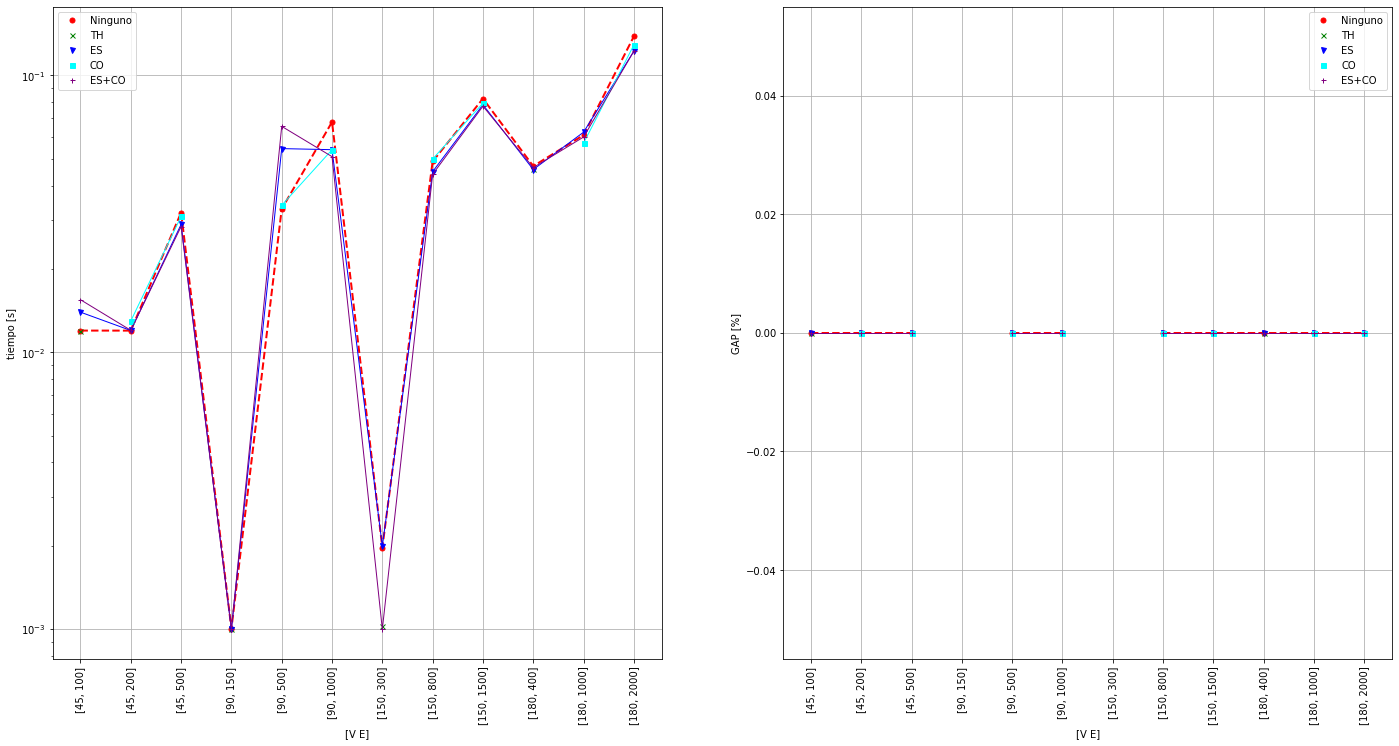

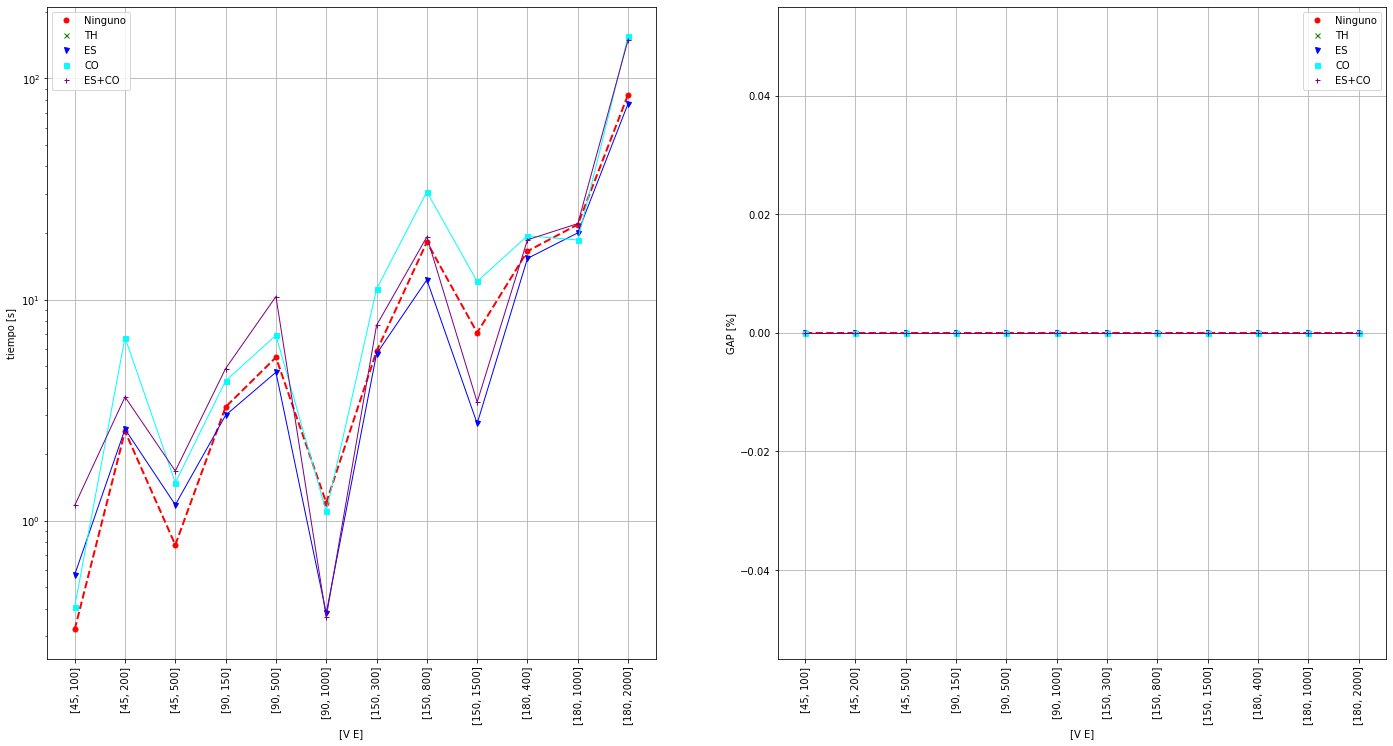

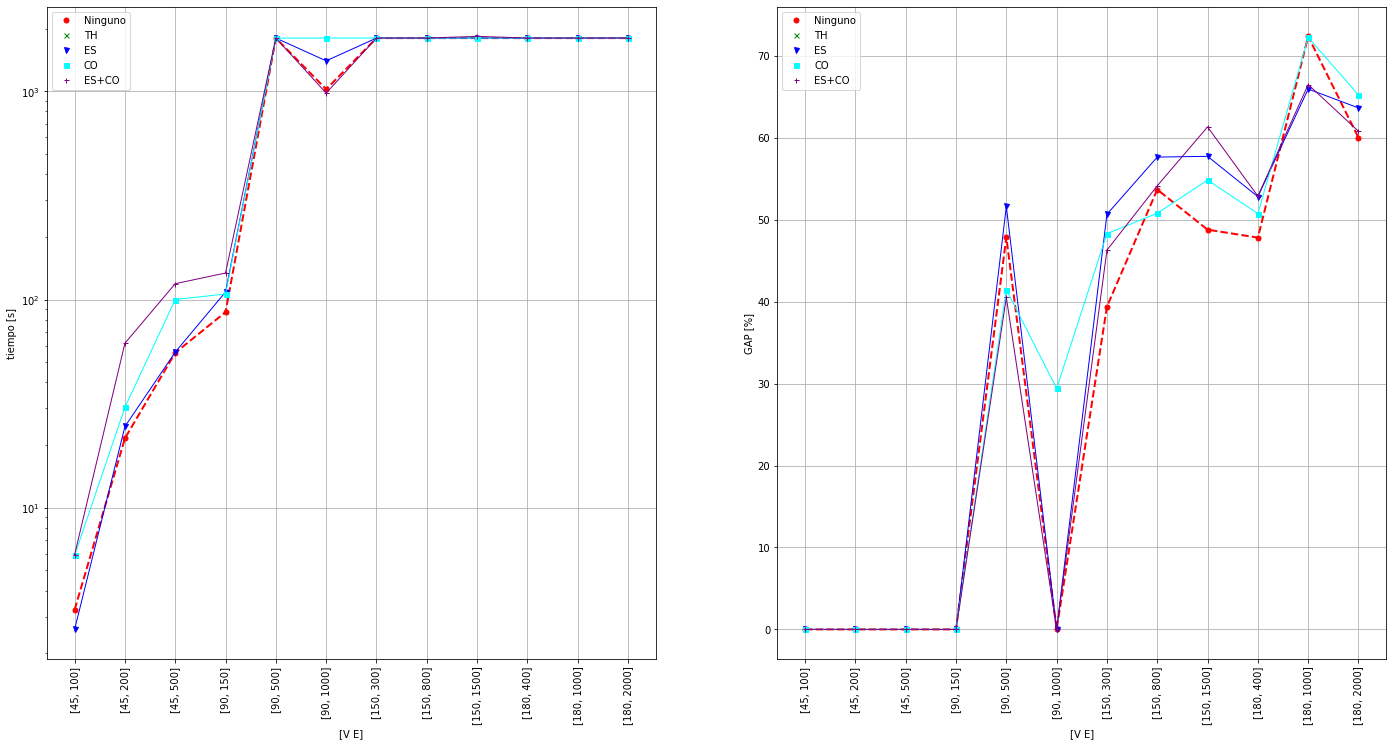

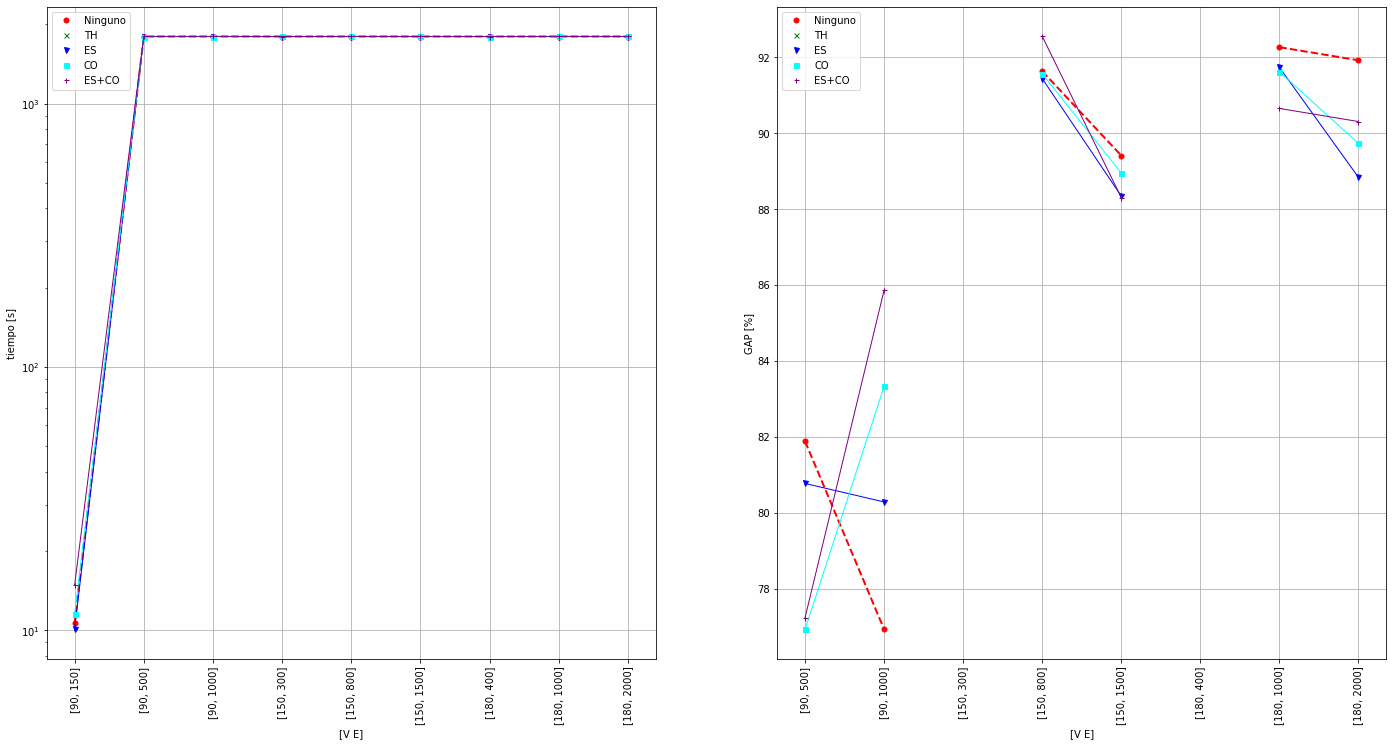

In [8]:
fig1 ,axs1 = plt.subplots(1,2,figsize=(24,12)) #tam2
fig2 ,axs2 = plt.subplots(1,2,figsize=(24,12)) #tam5
fig3 ,axs3 = plt.subplots(1,2,figsize=(24,12)) #tam10
fig4 ,axs4 = plt.subplots(1,2,figsize=(24,12)) #tam20

import matplotlib.lines as mlines

line_parm = {
            0:{'color':'red', 'marker':'o', 'linestyle':'dashed','linewidth':2, 'markersize':5, 'label':'Ninguno'},
            1:{'color':'green', 'marker':'x', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'TH'},
            2:{'color':'blue', 'marker':'v', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES'},
            3:{'color':'cyan', 'marker':'s', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'CO'},
            4:{'color':'purple', 'marker':'+', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES+CO'},
}
mod = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Ninguno'),
     mlines.Line2D([], [], color='green', marker='x', linestyle='None',
                        markersize=5, label='TH'),
     mlines.Line2D([], [], color='blue', marker='v', linestyle='None',
                        markersize=5, label='ES'),
     mlines.Line2D([], [], color='cyan', marker='s', linestyle='None',
                        markersize=5, label='CO'),
     mlines.Line2D([], [], color='purple', marker='+', linestyle='None',
                        markersize=5, label='ES+CO'),]

#TAM2
axs1[0].set_xticklabels(com2,rotation=90)
axs1[0].set_xlabel('[V E]')
axs1[0].set_yscale('log')
axs1[0].set_ylabel('tiempo [s]')
axs1[0].plot(com2,[x[0] for x in T_tam2],**line_parm[0])
axs1[0].plot(com2,[x[1] for x in T_tam2],**line_parm[1])
axs1[0].plot(com2,[x[2] for x in T_tam2],**line_parm[2])
axs1[0].plot(com2,[x[3] for x in T_tam2],**line_parm[3])
axs1[0].plot(com2,[x[4] for x in T_tam2],**line_parm[4])
axs1[0].legend(handles=mod)
axs1[0].grid(True)
axs1[1].set_xticklabels(com2,rotation=90)
axs1[1].set_xlabel('[V E]')
axs1[1].set_ylabel('GAP [%]')
axs1[1].plot(com2,[x[0] for x in G_tam2],**line_parm[0])
axs1[1].plot(com2,[x[1] for x in G_tam2],**line_parm[1])
axs1[1].plot(com2,[x[2] for x in G_tam2],**line_parm[2])
axs1[1].plot(com2,[x[3] for x in G_tam2],**line_parm[3])
axs1[1].plot(com2,[x[4] for x in G_tam2],**line_parm[4])
axs1[1].legend(handles=mod)
axs1[1].grid(True)
#fig1.suptitle('$|e_{max}|=2$',fontsize=36)
fig1.savefig('F3_tam2.jpg',bbox_inches='tight',dpi=300)

#TAM5
axs2[0].set_xticklabels(com5,rotation=90)
axs2[0].set_xlabel('[V E]')
axs2[0].set_yscale('log')
axs2[0].set_ylabel('tiempo [s]')
axs2[0].plot(com5,[x[0] for x in T_tam5],**line_parm[0])
axs2[0].plot(com5,[x[1] for x in T_tam5],**line_parm[1])
axs2[0].plot(com5,[x[2] for x in T_tam5],**line_parm[2])
axs2[0].plot(com5,[x[3] for x in T_tam5],**line_parm[3])
axs2[0].plot(com5,[x[4] for x in T_tam5],**line_parm[4])
axs2[0].legend(handles=mod)
axs2[0].grid(True)
axs2[1].set_xticklabels(com5,rotation=90)
axs2[1].set_xlabel('[V E]')
axs2[1].set_ylabel('GAP [%]')
axs2[1].plot(com5,[x[0] for x in G_tam5],**line_parm[0])
axs2[1].plot(com5,[x[1] for x in G_tam5],**line_parm[1])
axs2[1].plot(com5,[x[2] for x in G_tam5],**line_parm[2])
axs2[1].plot(com5,[x[3] for x in G_tam5],**line_parm[3])
axs2[1].plot(com5,[x[4] for x in G_tam5],**line_parm[4])
axs2[1].legend(handles=mod)
axs2[1].grid(True)
#fig2.suptitle('$|e_{max}|=5$',fontsize=36)
fig2.savefig('F3_tam5.jpg',bbox_inches='tight',dpi=300)

#TAM10
axs3[0].set_xticklabels(com10,rotation=90)
axs3[0].set_xlabel('[V E]')
axs3[0].set_yscale('log')
axs3[0].set_ylabel('tiempo [s]')
axs3[0].plot(com10,[x[0] for x in T_tam10],**line_parm[0])
axs3[0].plot(com10,[x[1] for x in T_tam10],**line_parm[1])
axs3[0].plot(com10,[x[2] for x in T_tam10],**line_parm[2])
axs3[0].plot(com10,[x[3] for x in T_tam10],**line_parm[3])
axs3[0].plot(com10,[x[4] for x in T_tam10],**line_parm[4])
axs3[0].legend(handles=mod)
axs3[0].grid(True)
axs3[1].set_xticklabels(com10,rotation=90)
axs3[1].set_xlabel('[V E]')
axs3[1].set_ylabel('GAP [%]')
axs3[1].plot(com10,[x[0] for x in G_tam10],**line_parm[0])
axs3[1].plot(com10,[x[1] for x in G_tam10],**line_parm[1])
axs3[1].plot(com10,[x[2] for x in G_tam10],**line_parm[2])
axs3[1].plot(com10,[x[3] for x in G_tam10],**line_parm[3])
axs3[1].plot(com10,[x[4] for x in G_tam10],**line_parm[4])
axs3[1].legend(handles=mod)
axs3[1].grid(True)
#fig3.suptitle('$|e_{max}|=10$',fontsize=36)
fig3.savefig('F3_tam10.jpg',bbox_inches='tight',dpi=300)

#TAM20
axs4[0].set_xticklabels(com20,rotation=90)
axs4[0].set_xlabel('[V E]')
axs4[0].set_yscale('log')
axs4[0].set_ylabel('tiempo [s]')
axs4[0].plot(com20,[x[0] for x in T_tam20],**line_parm[0])
axs4[0].plot(com20,[x[1] for x in T_tam20],**line_parm[1])
axs4[0].plot(com20,[x[2] for x in T_tam20],**line_parm[2])
axs4[0].plot(com20,[x[3] for x in T_tam20],**line_parm[3])
axs4[0].plot(com20,[x[4] for x in T_tam20],**line_parm[4])
axs4[0].legend(handles=mod)
axs4[0].grid(True)
axs4[1].set_xticklabels(com20,rotation=90)
axs4[1].set_xlabel('[V E]')
axs4[1].set_ylabel('GAP [%]')
axs4[1].plot(com20,[x[0] for x in G_tam20],**line_parm[0])
axs4[1].plot(com20,[x[1] for x in G_tam20],**line_parm[1])
axs4[1].plot(com20,[x[2] for x in G_tam20],**line_parm[2])
axs4[1].plot(com20,[x[3] for x in G_tam20],**line_parm[3])
axs4[1].plot(com20,[x[4] for x in G_tam20],**line_parm[4])
axs4[1].legend(handles=mod)
axs4[1].grid(True)
#fig4.suptitle('$|e_{max}|=20$',fontsize=36)
fig4.savefig('F3_tam20.jpg',bbox_inches='tight',dpi=300)
plt.show()